In [1]:
import numpy as np
import pandas as pd
import os 
import torch.utils.data as data
import keras
import random 
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras.preprocessing import image
from numpy import array
from keras import metrics
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('', 'dataset')

Using TensorFlow backend.


In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [4]:
skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes

In [5]:
def f(x):
    rnd = random.randint(0, 100)
    if x == 'nv' and rnd < 20:
        return '1'
    else:
        return '0'

skin_data['usable'] = skin_data['dx'].apply(lambda x: f(x))

In [6]:
skin_data['usable'].value_counts()

0    8730
1    1285
Name: usable, dtype: int64

In [7]:
cut_skin_data = skin_data[(skin_data['dx'] == 'bkl') |
                          ((skin_data['dx'] == 'nv') & (skin_data['usable'] == '1' )) | 
                          (skin_data['dx'] == 'mel')]
cut_skin_data['dx'].value_counts()

nv     1285
mel    1113
bkl    1099
Name: dx, dtype: int64

In [8]:
data = []
IMAGE_DIMS = (150, 100, 3)
def load_img_with_cv2(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    return image

for img_path in cut_skin_data['path']:
    data.append(load_img_with_cv2(img_path))

In [9]:
data = np.array(data, dtype='float') / 255.0
labels = np.array(cut_skin_data['dx'])
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [10]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [11]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

# Определим топологию нейронной сети 

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(150,100, 3), padding='SAME'))
model.add(layers.Conv2D(16, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3),activation='relu'))
model.add(layers.Conv2D(32, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),activation='relu'))
model.add(layers.Conv2D(64, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dense(3, activation = 'softmax'))
model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
                metrics=['categorical_accuracy']
)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 100, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 98, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 49, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 47, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 22, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 20, 64)        18496     
__________

# Обучим нейронную сеть 



In [14]:
history = model.fit(X_train, y_train, epochs=60, batch_size=128 )

Epoch 1/60
2797/2797 [==============================] - 20s 7ms/step - loss: 1.2857 - categorical_accuracy: 0.3557
Epoch 2/60
2797/2797 [==============================] - 5s 2ms/step - loss: 1.1411 - categorical_accuracy: 0.3829
Epoch 3/60
2797/2797 [==============================] - 5s 2ms/step - loss: 1.0852 - categorical_accuracy: 0.4001
Epoch 4/60
2797/2797 [==============================] - 5s 2ms/step - loss: 1.0868 - categorical_accuracy: 0.4255
Epoch 5/60
2797/2797 [==============================] - 5s 2ms/step - loss: 1.0315 - categorical_accuracy: 0.5063
Epoch 6/60
2797/2797 [==============================] - 5s 2ms/step - loss: 0.9924 - categorical_accuracy: 0.5299
Epoch 7/60
2797/2797 [==============================] - 5s 2ms/step - loss: 0.9679 - categorical_accuracy: 0.5366
Epoch 8/60
2797/2797 [==============================] - 5s 2ms/step - loss: 0.9851 - categorical_accuracy: 0.5334
Epoch 9/60
2797/2797 [==============================] - 5s 2ms/step - loss: 0.9174 - ca

# Построим графики результатов обучения нейронной сети 


In [15]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy'])


In [16]:
print(history.history['categorical_accuracy'])

[0.3557382914949239, 0.3829102611644037, 0.40007150515216056, 0.425455845623388, 0.5062567028864648, 0.5298534154593625, 0.5366464071415303, 0.5334286734083529, 0.578476940366597, 0.5706113698037556, 0.5974258127960939, 0.6149445833118208, 0.6153021095307929, 0.6310332487811776, 0.6338934571051709, 0.6496245984226454, 0.6610654269238221, 0.6660707907715907, 0.6599928494176568, 0.6857347147440033, 0.696102967550382, 0.6971755447582044, 0.7061136922198702, 0.711476582393162, 0.7332856621876929, 0.73328566395644, 0.7472291730922335, 0.7636753673590972, 0.7686807300987353, 0.782981767222248, 0.7969252771252089, 0.8076510540834699, 0.8255273507755485, 0.8348230239021212, 0.8405434401452136, 0.8548444769703835, 0.8666428313495689, 0.8426885953706462, 0.8956024319221175, 0.8712906693193287, 0.8970325341981609, 0.8923846985938338, 0.8973900601187902, 0.9045405796395057, 0.9138362536824172, 0.9256346086582884, 0.9238469800141014, 0.938863067465848, 0.9327851270708732, 0.9478012165470894, 0.9174

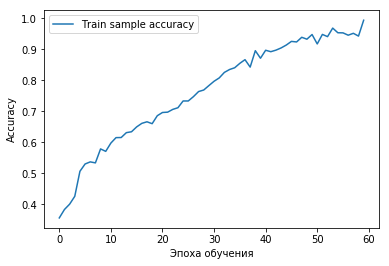

In [17]:
plt.plot(history.history['categorical_accuracy'], label='Train sample accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Функция для отрисовки промежуточных слоёв нейросети

In [37]:
def layers_pictures(activation):
    images_per_row = 16
    n_filters = activation.shape[2]
    size = activation.shape[1]
    size2 = activation.shape[2]
    n_cols = n_filters // images_per_row
    display_grid = np.zeros((n_cols * size, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size2 : (row + 1) * size2] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Проверим полученную модель на тестовой выборке 

In [18]:
score = model.evaluate(X_test, y_test, batch_size=128)
score

700/700 [==============================] - 3s 4ms/step


[2.9333528423309327, 0.6385714278902326]

# Выгрузим промежуточные изображения из слоёв нейронной сети 

# Первый слой 

In [32]:
First_layer = models.Model(inputs=model.input, outputs=model.layers[4].output)
First_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 150, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 100, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 98, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 49, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 47, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 45, 32)        9248      
Total params: 16,656
Trainable params: 16,656
Non-trainable params: 0
_________________________________________________________________


C:\Users\jurgen\Anaconda3\envs\gpuusage\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


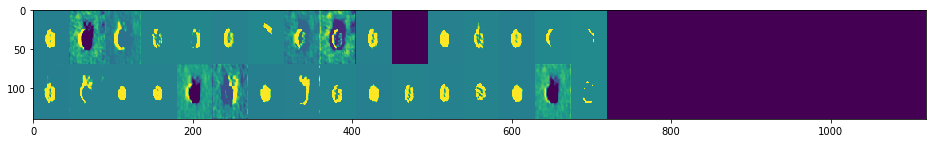

In [38]:
First_layer_activation = First_layer.predict(X_test)
layers_pictures(First_layer_activation)

# Второй слой 

In [36]:
Second_layer = models.Model(inputs=model.input, outputs=model.layers[7].output)
Second_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 150, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 100, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 98, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 49, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 47, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 22, 32)        0         
__________

C:\Users\jurgen\Anaconda3\envs\gpuusage\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


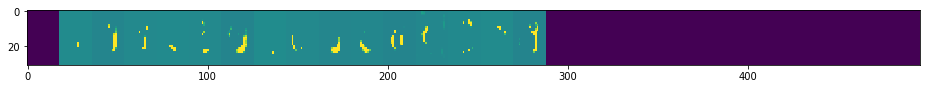

In [39]:
Second_layer_activation = Second_layer.predict(X_test)
layers_pictures(Second_layer_activation)